In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline
import vivarium, vivarium.test_util as vtu
from vivarium.framework.event import listens_for
from vivarium.framework.population import uses_columns

import pandas as pd
import json

In [6]:
n_simulants = 1500
n_days = 365
t_start = pd.Timestamp('2017-01-01')
t_timestep = 1
with open('../data/processed/p_return.json') as data_file:    
    return_rates = json.load(data_file)

In [17]:
class HIVCohortFollowUp:
    def __init__(self , return_rates):
        self.reports = {}
        self.return_rates = return_rates
    
    @listens_for('initialize_simulants')
    @uses_columns(['state', 'next_appointment', 'first_visit','follow_up_duration'])
    def initialize(self, event):
        # create the population dataframe
        population = pd.DataFrame(index=event.index)
        population['state'] = 'Out' #Followed, LTFU, Dead,   
        population['next_appointment'] = pd.NaT
        population['follow_up_duration'] = 0
        
        # Give first visit
        first_visit = np.round(np.random.uniform(0, 365, n_simulants))
        population['first_visit'] = t_start + pd.to_timedelta(first_visit, 'D')
        
        # Give first follow up
        rows = np.random.binomial(1, 0.5, size=len(population))
        population['next_appointment'] = population['first_visit'] + pd.Timedelta(days=7*4)
        
        population.loc[population['first_visit'] == t_start , 'state'] = 'Followed'
        
        # update the population in the model
        event.population_view.update(population)
        
    @listens_for('time_step')
    @uses_columns(['state', 'first_visit'], 'state == "Out"')
    def new_patients(self, event):
        df = event.population
        df.loc[df['first_visit'] == event.time, 'state'] = 'Followed'
        
        event.population_view.update(df)
        
    @listens_for('time_step')
    @uses_columns(['state', 'next_appointment'], 'state != "Out"')
    def next_appointment(self, event):
        df = event.population
        df.visit_delay = (event.time - df['next_appointment'])/ np.timedelta64(1, 'D')
        
        ordered_change_times = sorted(list(map(int , self.return_rates.keys())))
        
        min_chunk = str(ordered_change_times[0])
        chunk_1 = df[df.visit_delay <= float(min_chunk)]
        visit = np.random.binomial(1, self.return_rates[min_chunk], size=len(chunk_1))
        visitors = list(chunk_1.index[visit == 1])
        
        for i in range(1,len(ordered_change_times) - 1):
            chunk = str(ordered_change_times[i])
            chunk_i = df[(df.visit_delay > float(min_chunk)) & (df.visit_delay <= float(chunk))]
            visit = np.random.binomial(1, self.return_rates[chunk], size=len(chunk_i))
            visitors_i = list(chunk_i.index[visit == 1])
            visitors = visitors + visitors_i
            min_chunk = chunk
            
        max_chunk = str(ordered_change_times[len(ordered_change_times) - 1])
        chunk_n = df[df.visit_delay > float(max_chunk)]
        visit = np.random.binomial(1, self.return_rates[max_chunk], size=len(chunk_n))
        visitors_n = list(chunk_n.index[visit == 1])
        visitors = visitors + visitors_n
        
        df.loc[visitors, 'next_appointment'] = event.time + pd.Timedelta(days=7*4)
        
        df.visit_delay = (event.time - df['next_appointment'])/ np.timedelta64(1, 'D')
        df.loc[df.visit_delay > 90 , 'state'] = 'LTFU'
        df.loc[df.visit_delay <= 90 , 'state'] = 'Followed'
        
        event.population_view.update(df)
        
    @listens_for('time_step')
    @uses_columns(['state'], 'state != "Out"')
    def export_report_datapoint(self, event):
        date = event.time
        self.reports[date] = event.population.state.value_counts()

In [18]:
components = [HIVCohortFollowUp(return_rates)]
vtu.config.simulation_parameters.time_step = 1/365
simulation = vtu.setup_simulation(components, population_size=n_simulants, start=t_start)
vtu.pump_simulation(simulation, time_step_days=t_timestep, duration=pd.Timedelta(days=n_days))

A Jupyter Widget

365

In [19]:
print(simulation.population.population.state.value_counts());
print(simulation.population.population.state.value_counts() / len(simulation.population.population));

Followed    1254
LTFU         246
Name: state, dtype: int64
Followed    0.836
LTFU        0.164
Name: state, dtype: float64


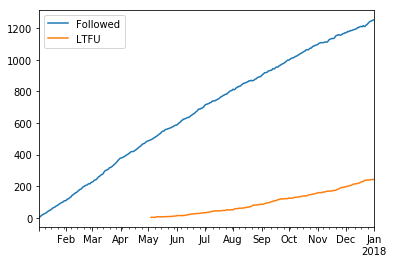

In [20]:
report_out = pd.DataFrame.from_dict(components[0].reports , orient='index')
report_out.plot()